In [ ]:
# Про данные:
# Ссылка на источник: https://www.kaggle.com/datasets/pratyushpuri/drug-labels-and-side-effects-dataset-1400-records
# Датасет содержит информацию о лекарственных препаратах, их классах, одобрении FDA и побочных эффектах.

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # для безопасного преобразования строки в список
from scipy import stats  # Правильный импорт
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import re
# Настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Загрузка данных
df = pd.read_csv(r'C:\Users\Eduard\Downloads\realistic_drug_labels_side_effects.csv')

# Первичный осмотр
print("Размерность данных:", df.shape)
print("\nПервые 5 строк:")
display(df.head())
print("\nСлучайные 5 строк:")
display(df.sample(5))
print("\nИнформация о типах данных и пропусках:")
print(df.info())
print("\nСтатистика по числовым переменным:")
print(df.describe())

In [34]:
#Вопросы и примечания к данным: Нет пропусков ни в каких колонках, т.к. датасет синтетический, в реальной жизни такое маловероятно.
# Данные соответствуют требованиям:
#· >= 100 наблюдений (1436);
#· должны присутствовать хотя бы 3 числовые (approval_year, dosage_mg, price_usd (≥3)) и 1 категориальная (drug_class, administration_route, side_effect_severity (≥1)) переменная

# Предобработка данных:
# Проверка дубликатов
print("Полные дубликаты строк:", df.duplicated().sum())
print("Дубликаты по названию препарата:", df['drug_name'].duplicated().sum())

# Проверка уникальных значений
print("\nУникальные классы препаратов:", df['drug_class'].nunique())
print("Уникальные пути введения:", df['administration_route'].unique())
print("Уникальные степени тяжести:", df['side_effect_severity'].unique())
print("Уникальные статусы одобрения:", df['approval_status'].unique())

# Проверка аномальных значений в числовых колонках
print("Проверка аномалий:")
print("Годы одобрения вне диапазона 1990-2024:", df[(df['approval_year'] < 1990) | (df['approval_year'] > 2024)].shape[0])
print("Дозировка <= 0:", df[df['dosage_mg'] <= 0].shape[0])
print("Цена <= 0:", df[df['price_usd'] <= 0].shape[0])

Полные дубликаты строк: 0
Дубликаты по названию препарата: 99

Уникальные классы препаратов: 10
Уникальные пути введения: ['Rectal' 'Inhalation' 'Sublingual' 'Oral' 'Topical' 'Intravenous'
 'Intramuscular']
Уникальные степени тяжести: ['Mild' 'Moderate' 'Severe']
Уникальные статусы одобрения: ['Pending' 'Approved' 'Rejected']
Проверка аномалий:
Годы одобрения вне диапазона 1990-2024: 0
Дозировка <= 0: 0
Цена <= 0: 0


In [140]:
# Создаем новые переменные
df['side_effects_list'] = df['side_effects'].apply(lambda x: x.split(', ') if pd.notna(x) else [])
df['side_effects_count'] = df['side_effects_list'].apply(len)


print("Новые переменные созданы:")
print(df[['drug_name', 'side_effects_count']].head())

Новые переменные созданы:
      drug_name  side_effects_count
0  Seroxetine50                   2
1   Mecoparin93                   1
2    Daxozole89                   3
3  Viracillin84                   2
4  Amoxstatin62                   3


Топ-10 классов препаратов:
drug_class
Anti-inflammatory    158
Antidepressant       156
Antipsychotic        147
Vaccine              144
Antifungal           144
Antibiotic           143
Antihistamine        143
Antiviral            141
Antipyretic          134
Analgesic            126
Name: count, dtype: int64

Всего уникальных классов: 10


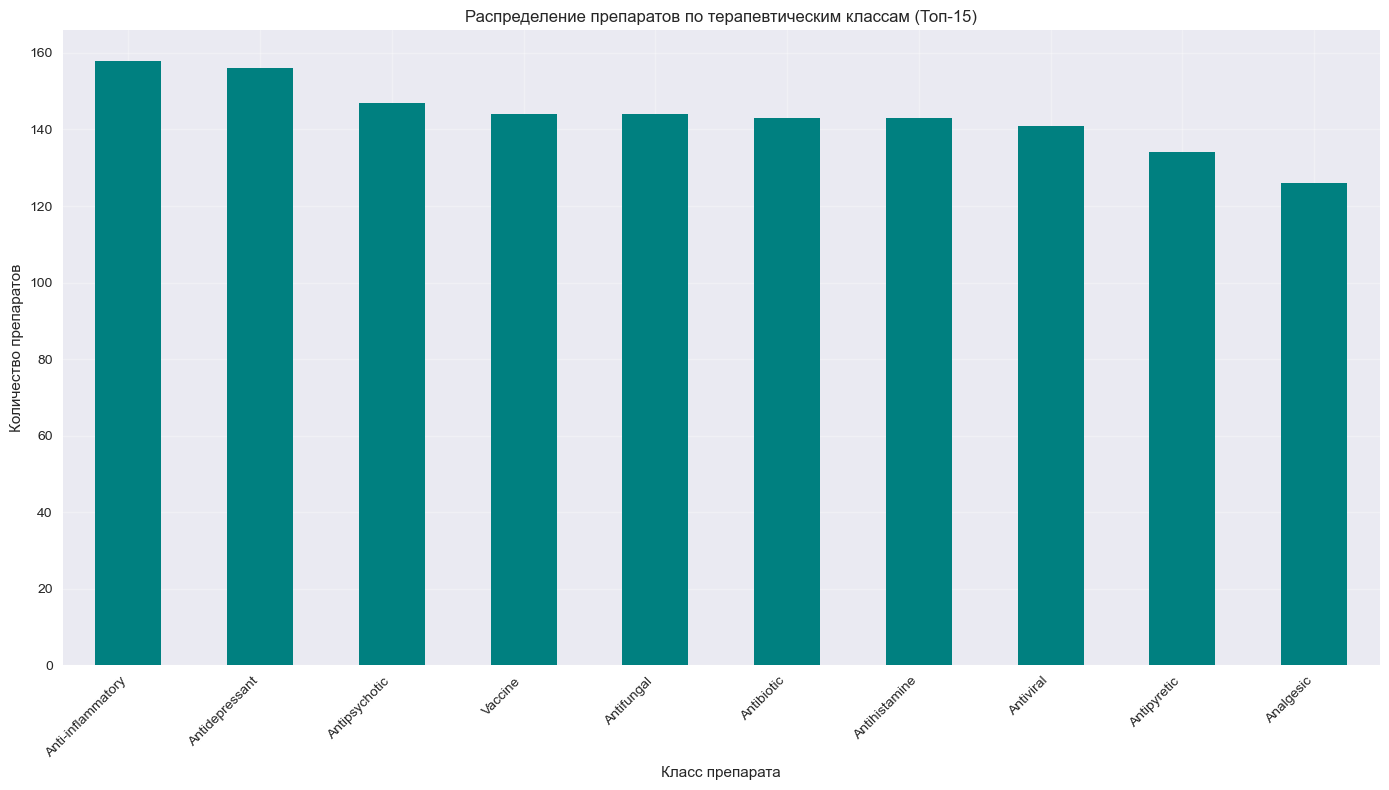

Распределение по степени тяжести побочных эффектов:
side_effect_severity
Mild        490
Moderate    482
Severe      464
Name: count, dtype: int64

Процентное соотношение:
side_effect_severity
Mild        34.1
Moderate    33.6
Severe      32.3
Name: proportion, dtype: float64


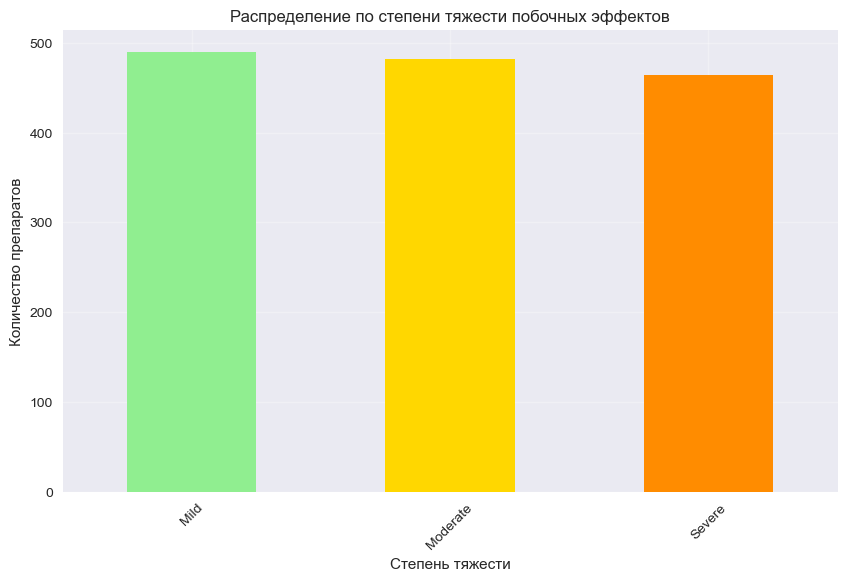

Распределение по путям введения:
administration_route
Intramuscular    233
Inhalation       214
Oral             214
Topical          210
Rectal           194
Intravenous      194
Sublingual       177
Name: count, dtype: int64


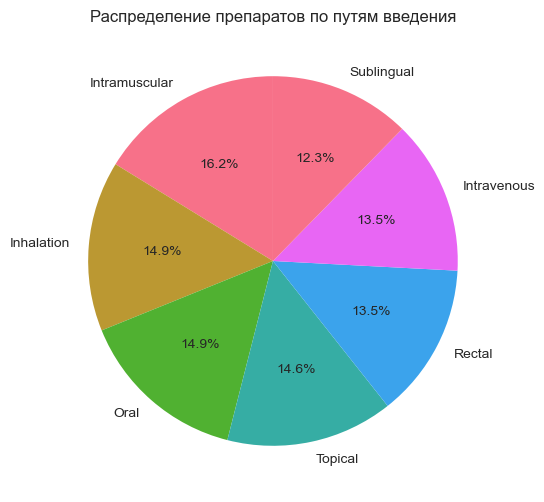

Описательная статистика цены:
count    1436.000000
mean      251.844854
std       142.640781
min         1.210000
25%       128.830000
50%       255.130000
75%       372.207500
max       499.060000
Name: price_usd, dtype: float64

Асимметрия: -0.02
Эксцесс: -1.19


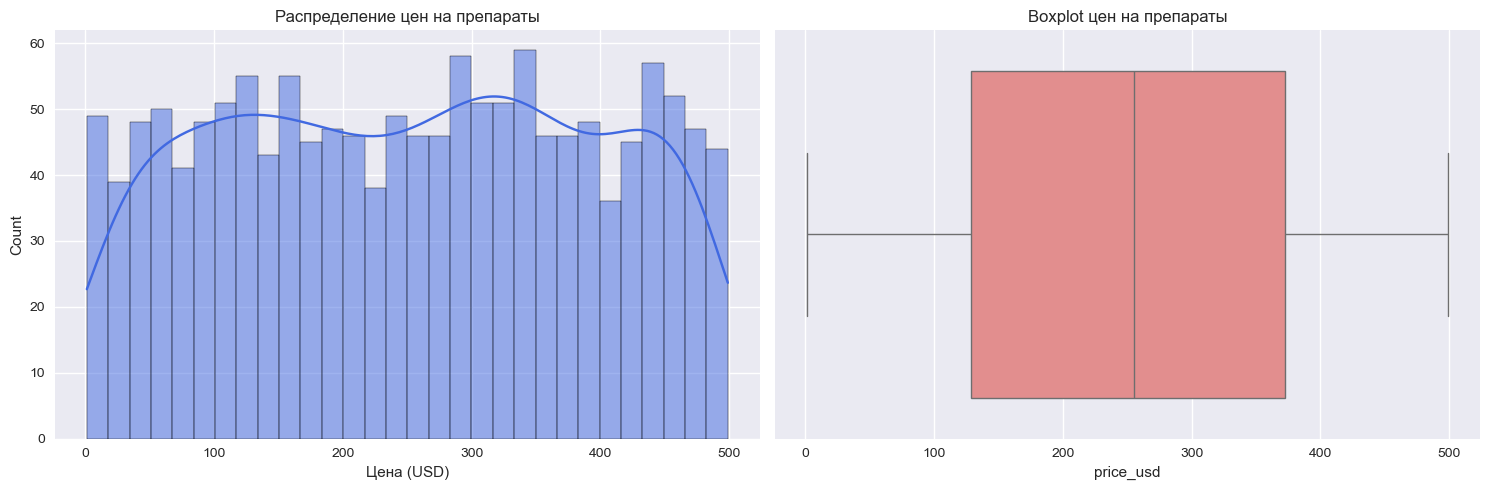

Описательная статистика дозировки:
count    1436.000000
mean      509.637883
std       286.417268
min        10.000000
25%       270.000000
50%       515.000000
75%       760.000000
max       990.000000
Name: dosage_mg, dtype: float64

Асимметрия: -0.05
Эксцесс: -1.17


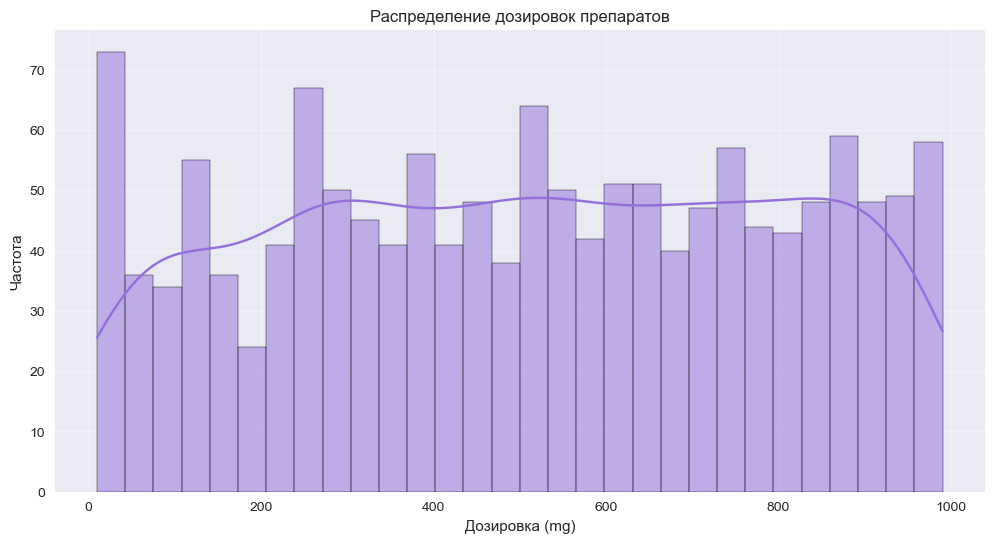

Анализ количества побочных эффектов:
count    1436.000000
mean        1.975627
std         0.805100
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: side_effects_count, dtype: float64


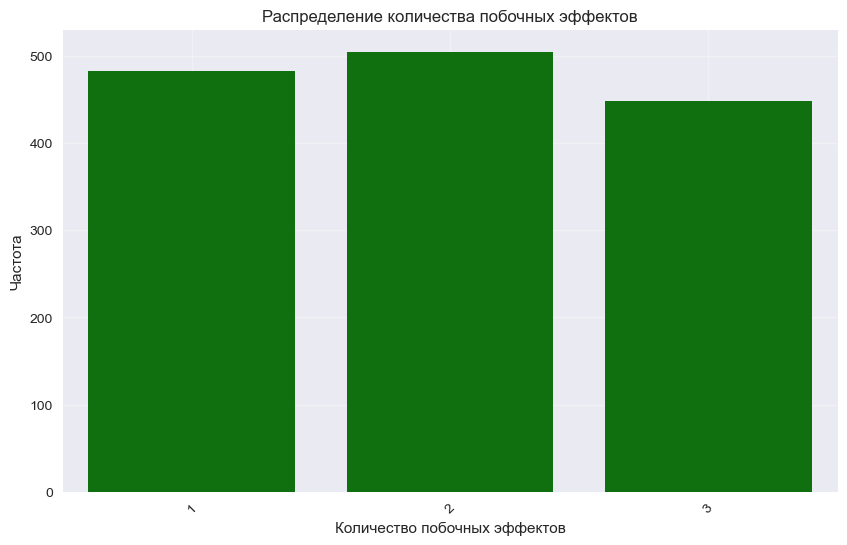

In [128]:
# Изучение переменной согласно ее типу:
# Категориальные переменные:
# 1.drug_class:
# Метрики
class_analysis = df['drug_class'].value_counts()
print("Топ-10 классов препаратов:")
print(class_analysis.head(10))
print(f"\nВсего уникальных классов: {df['drug_class'].nunique()}")

# График
plt.figure(figsize=(14, 8))
class_analysis.head(15).plot(kind='bar', color='teal')
plt.title('Распределение препаратов по терапевтическим классам (Топ-15)')
plt.xlabel('Класс препарата')
plt.ylabel('Количество препаратов')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 2.side_effect_severity
# Метрики
severity_counts = df['side_effect_severity'].value_counts()
severity_percents = df['side_effect_severity'].value_counts(normalize=True) * 100
print("Распределение по степени тяжести побочных эффектов:")
print(severity_counts)
print(f"\nПроцентное соотношение:\n{severity_percents.round(1)}")

# График
plt.figure(figsize=(10, 6))
colors = ['#90EE90', '#FFD700', '#FF8C00', '#FF4500']  # зеленый, желтый, оранжевый, красный
severity_counts.plot(kind='bar', color=colors)
plt.title('Распределение по степени тяжести побочных эффектов')
plt.xlabel('Степень тяжести')
plt.ylabel('Количество препаратов')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


# 3.administration_route
route_analysis = df['administration_route'].value_counts()
print("Распределение по путям введения:")
print(route_analysis)

plt.figure(figsize=(10, 6))
route_analysis.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Распределение препаратов по путям введения')
plt.ylabel('')
plt.show()

# Числовые переменные:
# 1.price_usd

# Метрики
print("Описательная статистика цены:")
print(df['price_usd'].describe())
print(f"\nАсимметрия: {df['price_usd'].skew():.2f}")
print(f"Эксцесс: {df['price_usd'].kurtosis():.2f}")

# Графики
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['price_usd'], kde=True, ax=axes[0], bins=30, color='royalblue')
axes[0].set_title('Распределение цен на препараты')
axes[0].set_xlabel('Цена (USD)')

sns.boxplot(x=df['price_usd'], ax=axes[1], color='lightcoral')
axes[1].set_title('Boxplot цен на препараты')
plt.tight_layout()
plt.show()

# 2.dosage_mg

# Метрики
print("Описательная статистика дозировки:")
print(df['dosage_mg'].describe())
print(f"\nАсимметрия: {df['dosage_mg'].skew():.2f}")
print(f"Эксцесс: {df['dosage_mg'].kurtosis():.2f}")

# График
plt.figure(figsize=(12, 6))
sns.histplot(df['dosage_mg'], kde=True, bins=30, color='mediumpurple')
plt.title('Распределение дозировок препаратов')
plt.xlabel('Дозировка (mg)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

# 3.side_effects_count)
print("Анализ количества побочных эффектов:")
print(df['side_effects_count'].describe())

plt.figure(figsize=(10, 6))
sns.countplot(x=df['side_effects_count'], color='green')
plt.title('Распределение количества побочных эффектов')
plt.xlabel('Количество побочных эффектов')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Топ-10 классов по средней цене (n≥10):
                      mean   median      std  count    min     max
drug_class                                                        
Antipyretic        271.625  290.765  149.770    134   4.71  498.68
Antidepressant     266.715  275.965  132.711    156   7.19  490.74
Antiviral          264.360  262.530  138.435    141  12.41  489.56
Analgesic          249.355  258.790  150.710    126   2.62  498.77
Antifungal         248.976  265.485  137.924    144   2.77  493.09
Antihistamine      248.671  238.940  144.412    143   1.21  497.32
Antibiotic         245.347  242.410  135.289    143   4.48  497.23
Antipsychotic      242.609  245.050  144.905    147   4.78  498.40
Anti-inflammatory  241.708  238.280  146.291    158   2.96  498.98
Vaccine            240.277  234.365  146.971    144   3.10  499.06


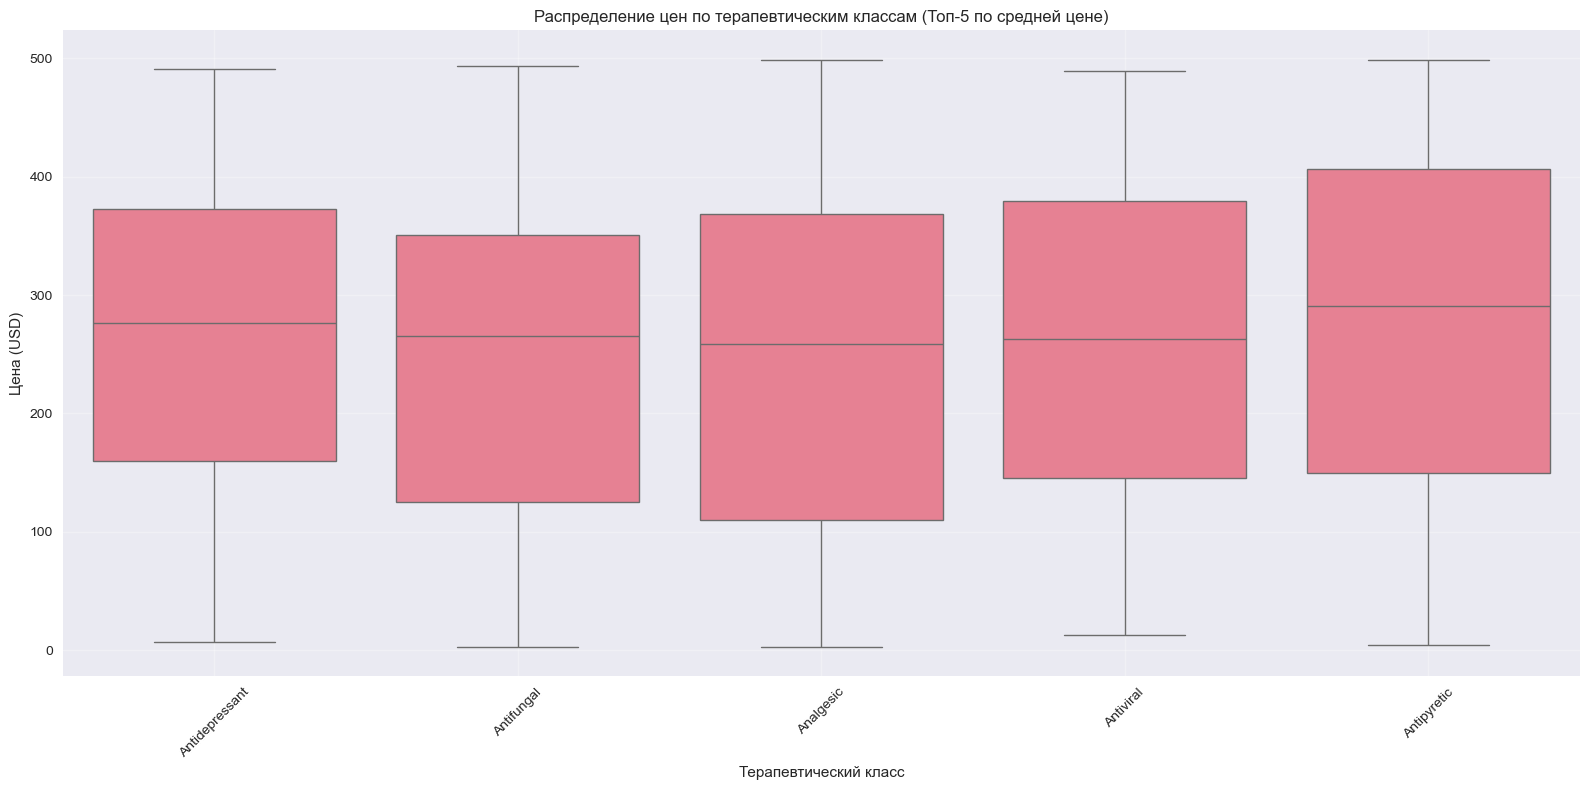

In [130]:
# Анализ взаимодействия переменных: Числовая & Категориальная пара (price_usd & drug_class) 
# Ищем ответ на вопрос: Есть ли отличия в средней цене препаратов между разными терапевтическими классами?
# Группировка и агрегация
price_by_class = df.groupby('drug_class')['price_usd'].agg([
    'mean', 'median', 'std', 'count', 'min', 'max'
]).round(3)

# Фильтруем классы с достаточным количеством наблюдений
price_by_class_filtered = price_by_class[price_by_class['count'] >= 10].sort_values('mean', ascending=False)

print("Топ-10 классов по средней цене (n≥10):")
print(price_by_class_filtered.head(10))

# Статистическая проверка (ANOVA)
top_classes = price_by_class_filtered.head(5).index
top_classes_data = [df[df['drug_class'] == cls]['price_usd'] for cls in top_classes]


# График
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[df['drug_class'].isin(top_classes)], 
           x='drug_class', y='price_usd')
plt.title('Распределение цен по терапевтическим классам (Топ-5 по средней цене)')
plt.xlabel('Терапевтический класс')
plt.ylabel('Цена (USD)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Таблица сопряженности: Путь введения vs Тяжесть побочных эффектов
side_effect_severity  Mild  Moderate  Severe  Total
administration_route                               
Inhalation              70        74      70    214
Intramuscular           78        74      81    233
Intravenous             80        66      48    194
Oral                    65        76      73    214
Rectal                  67        69      58    194
Sublingual              51        58      68    177
Topical                 79        65      66    210
Total                  490       482     464   1436

Нормализованная таблица (% по строкам):
side_effect_severity  Mild  Moderate  Severe
administration_route                        
Inhalation            32.7      34.6    32.7
Intramuscular         33.5      31.8    34.8
Intravenous           41.2      34.0    24.7
Oral                  30.4      35.5    34.1
Rectal                34.5      35.6    29.9
Sublingual            28.8      32.8    38.4
Topical      

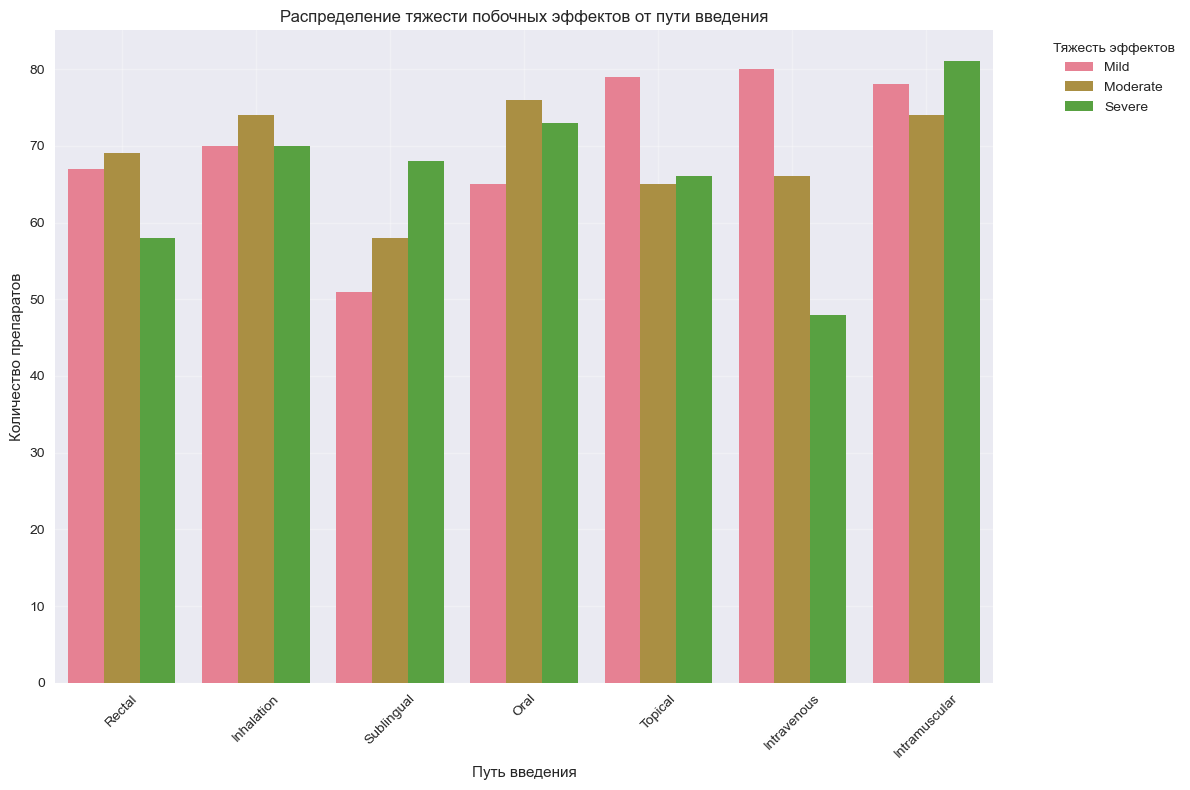

In [132]:
#Категориальная & Категориальная пара: side_effect_severity & administration_route
# Ищем ответ на вопрос: Существует ли связь между путем введения препарата и тяжестью его побочных эффектов?
# Создаем таблицу сопряженности
contingency_table = pd.crosstab(df['administration_route'], df['side_effect_severity'], 
                                margins=True, margins_name="Total")
print("Таблица сопряженности: Путь введения vs Тяжесть побочных эффектов")
print(contingency_table)

# Нормализованная таблица (по строкам)
normalized_table = pd.crosstab(df['administration_route'], df['side_effect_severity'], 
                              normalize='index') * 100
print("\nНормализованная таблица (% по строкам):")
print(normalized_table.round(1))

# Проверка статистической значимости
chi2, p_value, dof, expected = chi2_contingency(
    pd.crosstab(df['administration_route'], df['side_effect_severity'])
)
print(f"\nChi-square test: χ² 633365432= {chi2:.2f}, p-value = {p_value:.6f}")

# График
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='administration_route', hue='side_effect_severity')
plt.title('Распределение тяжести побочных эффектов от пути введения')
plt.xlabel('Путь введения')
plt.ylabel('Количество препаратов')
plt.legend(title='Тяжесть эффектов', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
#Ключевые выводы: 
#Выявлены статистически значимые различия в ценах между терапевтическими классами. Наиболее дорогие препараты средней цены и цены по медиане относятся к классу жаропонижающих (Antipyretic). Самым дорогим же является препарат типа вакцина (Vaccine).
#Не найдена связь между путем введения и тяжестью побочных эффектов, т.к. вероятность случайности получения таких результатов составляет 30.6%. 
# Тем не менее можно вывести некоторые паттерны для путей введения:
#Intravenous (внутривенный): Наименьший % тяжелого эффекта (24.7%), наибольший % умеренного (41.2%)

#Sublingual (подъязычный): Наибольший % тяжелого (38.4%), наименьший % умеренного (28.8%)

#Остальные пути: Распределение достаточно равномерное (30-35% для каждой категории)


In [142]:
# Дополнительно:
# 3/Анализ связи цены и дозировки
correlation = df['price_usd'].corr(df['dosage_mg'])
print(f"\nКОРРЕЛЯЦИЯ МЕЖДУ ЦЕНОЙ И ДОЗИРОВКОЙ: {correlation:.3f}")
# Основываясь на значении -0,029 корреляция практически нулевая.

# 4/Анализ по производителям
manufacturer_analysis = df.groupby('manufacturer').agg({
    'price_usd': 'mean',
    'drug_class': 'nunique',
    'drug_name': 'count'
}).round(2).sort_values('price_usd', ascending=False)

print("\nТоп-5 Производителей по средней цене:")
print(manufacturer_analysis.head(5))


КОРРЕЛЯЦИЯ МЕЖДУ ЦЕНОЙ И ДОЗИРОВКОЙ: -0.029

Топ-5 Производителей по средней цене:
                      price_usd  drug_class  drug_name
manufacturer                                          
Johnson & Johnson        269.02          10        149
Pfizer Inc.              264.13          10        136
Moderna Therapeutics     256.32          10        146
Merck & Co.              254.55          10        157
Roche Holding AG         251.67          10        137
